# Sparse-direct solvers in Julia

In this notebook, we construct some typical sparse matrices (the type that would arise from discretizing an elliptic PDE) in Julia, explore how they are represented and visualized, look at sparse-direct solvers via sparse-Cholesky factorization, and examine the impact of the matrix ordering on the sparse-direct solver.

In [1]:
using LinearAlgebra, SparseArrays

## A nice sparse matrix: discrete Laplacian

As a "nice" example of a sparse matrix, which has a structure typical of many applications arising from discretized PDEs and similar situations, let us consider a **discrete Laplacian**, analogous to $-\nabla^2 = -\partial^2/\partial x^2 - \partial^2/\partial y^2$ on a 2d $n_1 \times n_2$ grid, with $m = n_1 n_2$ degrees of freedom.  The $m\times m$ matrix resulting from a classic [five-point stencil](http://en.wikipedia.org/wiki/Five-point_stencil) on a 2d grid is sparse ($< 5m$ nonzero entries) and is **real-symmetric** and **positive-definite**.

How this matrix is constructed is outside the scope of 18.335, but see my [notes from 18.303](https://github.com/mitmath/18303/raw/fall16/lecture-10.pdf) on the subject.  Essentially, we first construct a 1d "difference" matrix $D$ analogous to $\partial/\partial x$ on a 1d grid with Dirichlet (zero) boundary conditions, then from the second-difference matrix analogous to $-\partial^2/\partial x^2$ via $D^T D$, and finally we put these 1d matrices together into a "2d" matrix via [Kronecker products](http://en.wikipedia.org/wiki/Kronecker_product) (`kron` in Julia).  We use `spdiagm` to construct the (bidiagonal) difference matrices as **sparse** matrices in Julia, and as a result all of the subsequent matrix products are computed in an efficient sparse fashion.

In [2]:
# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end

∇² (generic function with 1 method)

The resulting matrix data structure (technically in [compressed-sparse-column/CSC](http://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_column_.28CSC_or_CCS.29) format) only stores the nonzero entries:

In [3]:
∇²(4,3)

12×12 SparseMatrixCSC{Float64, Int64} with 46 stored entries:
  4.0  -1.0    ⋅     ⋅   -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -1.0   4.0  -1.0    ⋅     ⋅   -1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0   4.0  -1.0    ⋅     ⋅   -1.0    ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -1.0   4.0    ⋅     ⋅     ⋅   -1.0    ⋅     ⋅     ⋅     ⋅ 
 -1.0    ⋅     ⋅     ⋅    4.0  -1.0    ⋅     ⋅   -1.0    ⋅     ⋅     ⋅ 
   ⋅   -1.0    ⋅     ⋅   -1.0   4.0  -1.0    ⋅     ⋅   -1.0    ⋅     ⋅ 
   ⋅     ⋅   -1.0    ⋅     ⋅   -1.0   4.0  -1.0    ⋅     ⋅   -1.0    ⋅ 
   ⋅     ⋅     ⋅   -1.0    ⋅     ⋅   -1.0   4.0    ⋅     ⋅     ⋅   -1.0
   ⋅     ⋅     ⋅     ⋅   -1.0    ⋅     ⋅     ⋅    4.0  -1.0    ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0    ⋅     ⋅   -1.0   4.0  -1.0    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0    ⋅     ⋅   -1.0   4.0  -1.0
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -1.0    ⋅     ⋅   -1.0   4.0

Internally, sparse matrices in Julia are stored in [compressed sparse column (CSC)](http://netlib.org/linalg/html_templates/node92.html) format, similar to Matlab.   

We can see the internal structure using the `dump` function.   It consists of the size (`m` and `n`), an array `nzval` of the nonzero matrix entries, an array `rowval` of the corresponding rows, and and array `colptr` that holds the indices of the *starts* of each column in `nzval` and `rowval`.

In [4]:
dump(∇²(4,3))

SparseMatrixCSC{Float64, Int64}
  m: Int64 12
  n: Int64 12
  colptr: Array{Int64}((13,)) [1, 4, 8, 12, 15, 19, 24, 29, 33, 36, 40, 44, 47]
  rowval: Array{Int64}((46,)) [1, 2, 5, 1, 2, 3, 6, 2, 3, 4  …  9, 10, 11, 7, 10, 11, 12, 8, 11, 12]
  nzval: Array{Float64}((46,)) [4.0, -1.0, -1.0, -1.0, 4.0, -1.0, -1.0, -1.0, 4.0, -1.0  …  -1.0, 4.0, -1.0, -1.0, -1.0, 4.0, -1.0, -1.0, -1.0, 4.0]


We can use the `Matrix` constructor to convert it back to a dense matrix (which is grossly inefficient for large sizes because it stores all zeros explicitly, but can be handy and even efficient for small matrices):

In [5]:
Matrix(∇²(4,3))

12×12 Matrix{Float64}:
  4.0  -1.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0   4.0  -1.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   4.0  -1.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   4.0   0.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0
 -1.0   0.0   0.0   0.0   4.0  -1.0   0.0   0.0  -1.0   0.0   0.0   0.0
  0.0  -1.0   0.0   0.0  -1.0   4.0  -1.0   0.0   0.0  -1.0   0.0   0.0
  0.0   0.0  -1.0   0.0   0.0  -1.0   4.0  -1.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0   0.0  -1.0   4.0   0.0   0.0   0.0  -1.0
  0.0   0.0   0.0   0.0  -1.0   0.0   0.0   0.0   4.0  -1.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0  -1.0   4.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0  -1.0   4.0  -1.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0   0.0  -1.0   4.0

For larger sparse matrices, Julia displays the sparsity pattern (using [Braille characters](https://en.wikipedia.org/wiki/Braille_Patterns), actually, which yieldds a portable text-based "plot") rather than the values of the entries, by default:

In [6]:
∇²(10,5)

50×50 SparseMatrixCSC{Float64, Int64} with 220 stored entries:
⠻⣦⡀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢄⠀⠀⠈⠛⣤⡀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠑⢄⠀⠀⠈⠻⣦⡀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠑⢄⠀⠀⠈⠻⣦⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠻⣦⡀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠻⣦⡀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠛⣤⡀⠀⠀⠑⢄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠻⣦⡀⠀⠀⠑⢄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠻⣦⠀⠀⠀⠑⢄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠻⣦⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠻⣦⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠀⠀⠀⠈⠛

We can also use the `spy` function in PyPlot (analogous to the function of the same name in Matlab) to visualize the sparse-matrix structure in a higher-quality plot:

In [7]:
using PyPlot

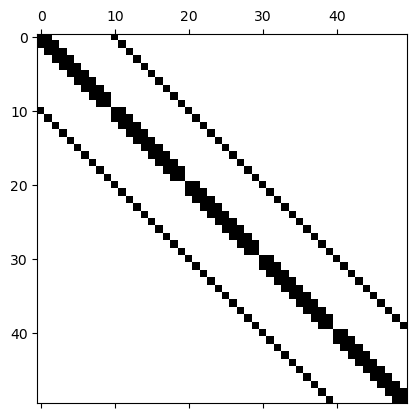

PyObject <matplotlib.image.AxesImage object at 0x7f960b599590>

In [8]:
spy(∇²(10,5))

## Sparse Cholesky factorization

Since our matrix is real-symmetric positive-definite, we can solve systems of equations using the Cholesky factorization, which is provided in an abstract form by the `cholesky` function.

Recall that Cholesky is conceptually the same as LU factorization (Gaussian elimination), except that it arranges for $L=U^*$ to save half the work and memory, so if you want you can think of the factors shown below as the $U$ from LU.

For a sparse matrix, Julia calls the CHOLMOD sparse-direct Cholesky algorithms in [SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html).  In fact, the Cholesky factorization is also called automatically by `\` (falling back to LU for non-posdef matrices), and we can also call a sparse LU factorization (from UMFPACK) explicitly via `lu`.   Let's time them for a big problem:

In [9]:
using BenchmarkTools

A = ∇²(600,200) # a 120,000×120,000 matrix
b = rand(600*200)
@btime $A \ $b
@btime cholesky($A) \ $b
@btime lu($A) \ $b;

  181.916 ms (52 allocations: 103.94 MiB)
  182.168 ms (54 allocations: 109.42 MiB)
  436.803 ms (71 allocations: 185.26 MiB)


Note that storing a dense matrix of this size would require $8\times120000^2$ bytes, or about **100 GiB**!   On my machine, Cholesky factorization of a $1200\times1200$ dense matrix takes about 0.03 seconds for me, so scaling by $100^3$ yields an expected dense-matrix factorization time (on a theoretical version of my machine with enough memory) of about **8.3 hours**.

The `spy` function doesn't know how to visualize a `cholesky` object directly, but we can convert it to an ordinary sparse matrix via `sparse` and then plot its nonzero patterns.  By default, `cholesky` uses an [approximate minimum-degree algorithm](http://en.wikipedia.org/wiki/Minimum_degree_algorithm) (AMD), that does a darn good job with the sparse-Laplacian matrix here:

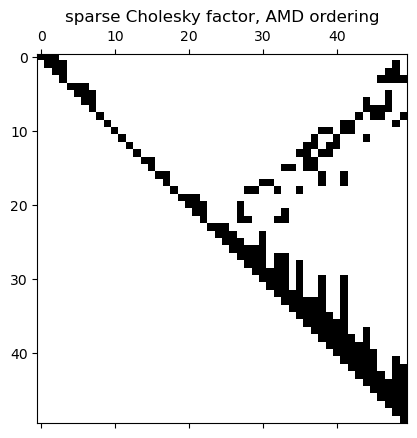

PyObject Text(0.5, 1.0641835016835017, 'sparse Cholesky factor, AMD ordering')

In [10]:
spy(sparse(cholesky(∇²(10,5)).L)')
title("sparse Cholesky factor, AMD ordering")

### Choosing our own Cholesky permutation

To investigate the effect of different permutations on the Cholesky fill-in, it is useful to provide a permutation different than the default AMD permutation.   Fortunately, the CHOLMOD package allows you to provide a user-defined permutation when computing the factorization, and Julia gives access to this feature via a `perm` argument to `cholesky`.

#### Natural-order Cholesky

First, let us try sparse Cholesky with no reordering at all, by just passing `1:m` as the permutation.  As expected, this results in a lot more fill-in, and in particular we expect $\Theta(m^{3/2})$ fill:

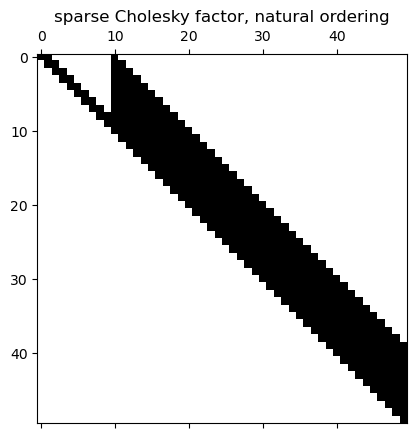

PyObject Text(0.5, 1.0641835016835017, 'sparse Cholesky factor, natural ordering')

In [11]:
spy(sparse(cholesky(∇²(10,5), perm=1:50).L)')
title("sparse Cholesky factor, natural ordering")

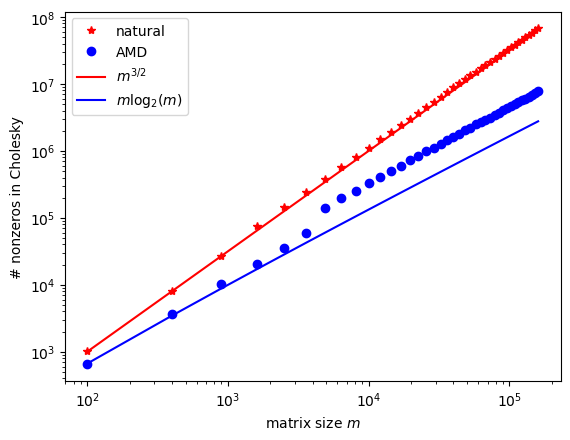

PyObject <matplotlib.legend.Legend object at 0x7f95cf03db50>

In [12]:
N = 10:10:400
m = N.^2
loglog(m, [nnz(cholesky(∇²(n,n), perm=1:n*n)) for n in N], "r*")
loglog(m, [nnz(cholesky(∇²(n,n))) for n in N], "bo")
loglog(m, m.^(3/2), "r-")
loglog(m, m .* log2.(m), "b-")
xlabel(L"matrix size $m$")
ylabel("# nonzeros in Cholesky")
legend(["natural", "AMD", L"m^{3/2}", L"m \log_2(m)"], loc="upper left")

#### Nested dissection

Since we know that our matrix comes from a 5-point stencil on a perfectly regular grid, it is straightforward to implement
a nested-dissection ordering by a little function that recursively divides the grid in two along the longer axis:

In [13]:
# return nested-dissection permutation for an m × n grid (in column-major order).  ndissect is an optional
# number of dissection steps before reverting to the normal ordering, and lm is an optional leading dimension
# (used for indexing computations).
function nest(m,n, ndissect=30, lm=m)
    if ndissect <= 0 || m*n < 5
        return vec([i + (j-1)*lm for i=1:m, j=1:n])
    elseif m >= n
        msep = div(m,2)
        N1 = nest(msep-1,n, ndissect-1, lm)
        N2 = nest(m-msep,n, ndissect-1, lm) .+ msep
        Ns = msep .+ (0:n-1)*lm
        return [N1; N2; Ns]
    else
        nsep = div(n,2)
        N1 = nest(m,nsep-1, ndissect-1, lm)
        N2 = nest(m,n-nsep, ndissect-1, lm) .+ nsep*lm
        Ns = (1:m) .+ (nsep-1)*lm
        return [N1; N2; Ns]
    end
end

nest (generic function with 3 methods)

As a quick check, let's make sure that it outputs each index exactly once:

In [14]:
sort(nest(30,60)) == [1:30*60;]

true

Just by looking at the sparsity pattern, it's clearly a bit different from AMD:

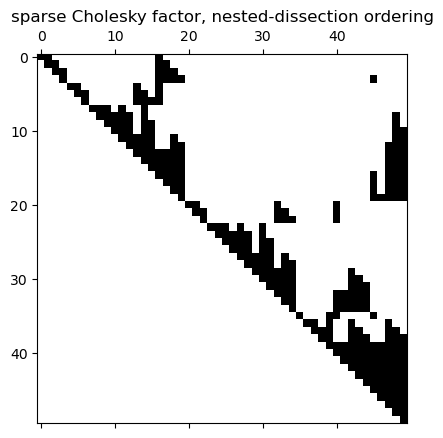

PyObject Text(0.5, 1.0641835016835017, 'sparse Cholesky factor, nested-dissection ordering')

In [15]:
spy(sparse(cholesky(∇²(10,5), perm=nest(10,5)).L)')
title("sparse Cholesky factor, nested-dissection ordering")

We can use the `nnz` function to compare the fill-in for natural, nested-dissection, and AMD ordering for a $100\times120$ grid.   CHOLMOD's default ordering (AMD plus a postorder permutation) is actually pretty darn good, and slightly beats our hand-rolled nested-dissection; both are about 3 times better than natural order:

In [16]:
m = 100
n = 120
nnz(cholesky(∇²(m,n), perm=1:m*n)), nnz(cholesky(∇²(m,n), perm=nest(m,n))),  nnz(cholesky(∇²(m,n)))

(1333457, 435519, 396160)

We can also look at the effect of different levels of nesting:

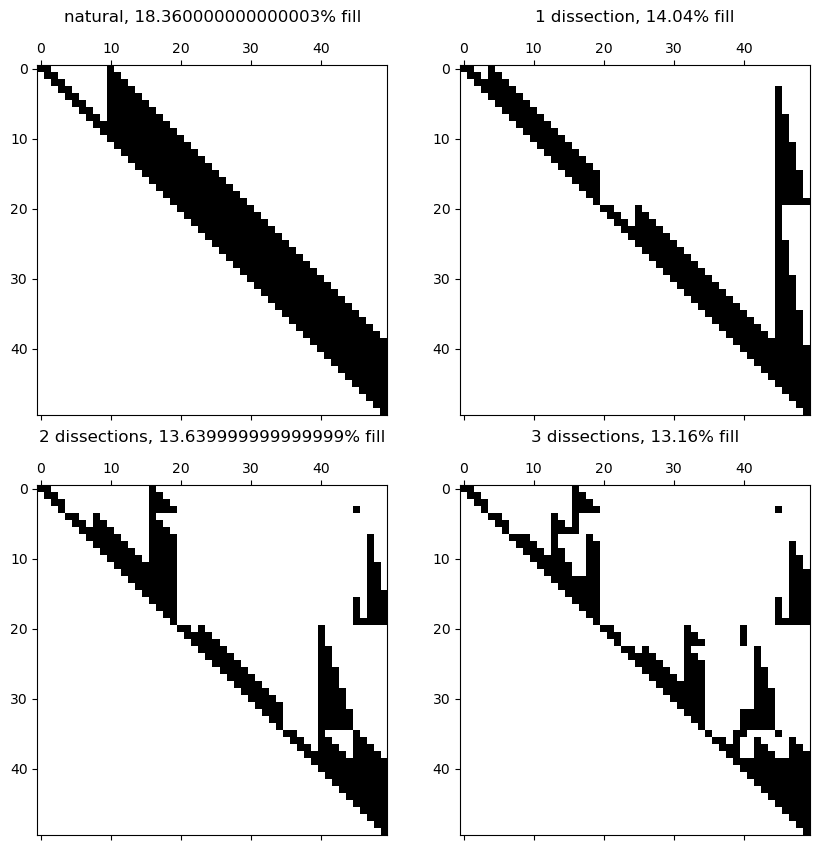

PyObject Text(0.5, 1.1, '3 dissections, 13.16% fill')

In [17]:
figure(figsize=(10,10))
n1, n2 = 10, 5
m = n1*n2

subplot(2,2,1)
F = cholesky(∇²(n1,n2), perm=1:m)
spy(sparse(F.L)')
title("natural, $(nnz(F)/m^2*100)% fill", y=1.1)

subplot(2,2,2)
F = cholesky(∇²(n1,n2), perm=nest(n1,n2, 1))
spy(sparse(F.L)')
title("1 dissection, $(nnz(F)/m^2*100)% fill", y=1.1)

subplot(2,2,3)
F = cholesky(∇²(n1,n2), perm=nest(n1,n2, 2))
spy(sparse(F.L)')
title("2 dissections, $(nnz(F)/m^2*100)% fill", y=1.1)

subplot(2,2,4)
F = cholesky(∇²(n1,n2), perm=nest(n1,n2, 3))
spy(sparse(F.L)')
title("3 dissections, $(nnz(F)/m^2*100)% fill", y=1.1)